# Analysis of the Cackling Goose (Branta hutchinsii) and Associated Subspecies

Author: Carolyn Lee

In [37]:
import numpy as np
import pandas as pd
import warnings
import GooseUtils
import seaborn as sns
import matplotlib.pyplot as plt

# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

Import and trim relevant data. This notebook focuses only on data related to the Anser albifrons (species id: 1710) and its subspecies Anser albifrons elgasi (species id: 1719). This roughly corresponds to $222,322$ rows of data.

In [31]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 3 data from the relevant CSV file
goose_data_raw = pd.read_csv('cacklingNABBP_2023_grp03.csv')

# Filter out all irrelevant species
goose_data_raw = goose_data_raw[(goose_data_raw['SPECIES_ID'] == 1700) | (goose_data_raw['SPECIES_ID'] == 1710)]

In [32]:
#
# Get all relevant columns and display basic information about the data
#

# Retrieve all relevant columns
goose_data = goose_data_raw[['BAND', 
                             'ORIGINAL_BAND', 
                             'OTHER_BANDS', 
                             'EVENT_DATE', 
                             'EVENT_DAY', 
                             'EVENT_MONTH', 
                             'EVENT_YEAR', 
                             'LAT_DD', 
                             'LON_DD', 
                             'COORD_PREC']]

# Display number of non-null entries in each column
display(goose_data.count())

BAND             474382
ORIGINAL_BAND    474382
OTHER_BANDS        1378
EVENT_DATE       474382
EVENT_DAY        474382
EVENT_MONTH      474382
EVENT_YEAR       474382
LAT_DD           474119
LON_DD           474119
COORD_PREC       474291
dtype: int64

A large number of the date cells (~ 5,000) do not work with the `pd.to_datetime()` function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

1. If the `'EVENT_DATE'` column already has a valid date that works with `pd.to_datetime()`, it will be the date used.
2. Otherwise, if the `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` column all form a date that works with `pd.to_datetime()`, it will be the date used.
3. If neither of the above work, `NaT` will be assigned and the row will be dropped.

In [33]:
#
# Clean time-related columns as described above.

goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

# Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns BEFORE DROPPING THEM
dates_from_columns = pd.to_datetime(
    goose_data['EVENT_MONTH'].astype(str) + '/' +
    goose_data['EVENT_DAY'].astype(str) + '/' +
    goose_data['EVENT_YEAR'].astype(str),
    format='%m/%d/%Y',
    errors='coerce'
)

# Fill in all NaT values that can be filled with the guesses from the previous line.
goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

# Remove all rows where EVENT_DATE is still NaT after the above operations.
goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

# drop EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns
goose_data = goose_data.drop(labels=['EVENT_MONTH', 'EVENT_DAY', 'EVENT_YEAR'], axis=1)


/var/folders/_9/n_lpr4gj0f3fl6nv_b83c5x00000gp/T/ipykernel_7035/3914865308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')
/var/folders/_9/n_lpr4gj0f3fl6nv_b83c5x00000gp/T/ipykernel_7035/3914865308.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)


In [34]:
#
# Clean the coordinates columns as described above.
#

# Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

# Filter out all rows with unusable or useless coordinate precision values as outlined above.
goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                     (goose_data['COORD_PREC'] == 12) | \
                     (goose_data['COORD_PREC'] == 18) | \
                     (goose_data['COORD_PREC'] == 28) | \
                     (goose_data['COORD_PREC'] == 33) | \
                     (goose_data['COORD_PREC'] == 38) | \
                     (goose_data['COORD_PREC'] == 72))]

Additionally, a new column with lattitude and longitude uncertainties will be made whose values obey the following rules:
1. If the `COORD_PREC` corresponds to an exact location (is `0`), then the uncertainty is $5*10^{6}$ to account for limits in the number of significant digits given by the data.
2. If the `COORD_PREC` corresponds to a 1-minute block (is `1`), then the uncertainty is $\frac{1}{120} \approx 0.01$ degrees (rounded up) since the coordinates are in the centroid of the block.
3. If the `COORD_PREC` corresponds to a 10-minute block (is `10`), then the uncertainty is $\frac{1}{12} \approx 0.1$ degrees (rounded up) since the coordinates are in the centroid of the block.
4. If the `COORD_PREC` corresponds to a 1-degree block (is `60`), then the uncertainty is $0.5$ degrees since the coordinates are in the centroid of the block.
5. If the `COORD_PREC` corresponds to a county (is `7`), then the uncertainty will be $0.25$ degrees by estimate (since the average county land area is 1090.69 degrees and a sqaure of that size is around $0.5$ degrees in lattitude and longitude)
6. If the `COORD_PREC` corresponds to a town/area (is `11`), then the uncertainty will be $0.25$ degrees by estimate (since each town should be smaller than a county and thus have less uncertainty associated with it)

In [ ]:
#
# Perform the coordinate precision conversion as described above.
#

# Compute coording uncertainties
goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_precision(x))

# Drop the old column
goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

Creating heatmap with 468687 coordinate points


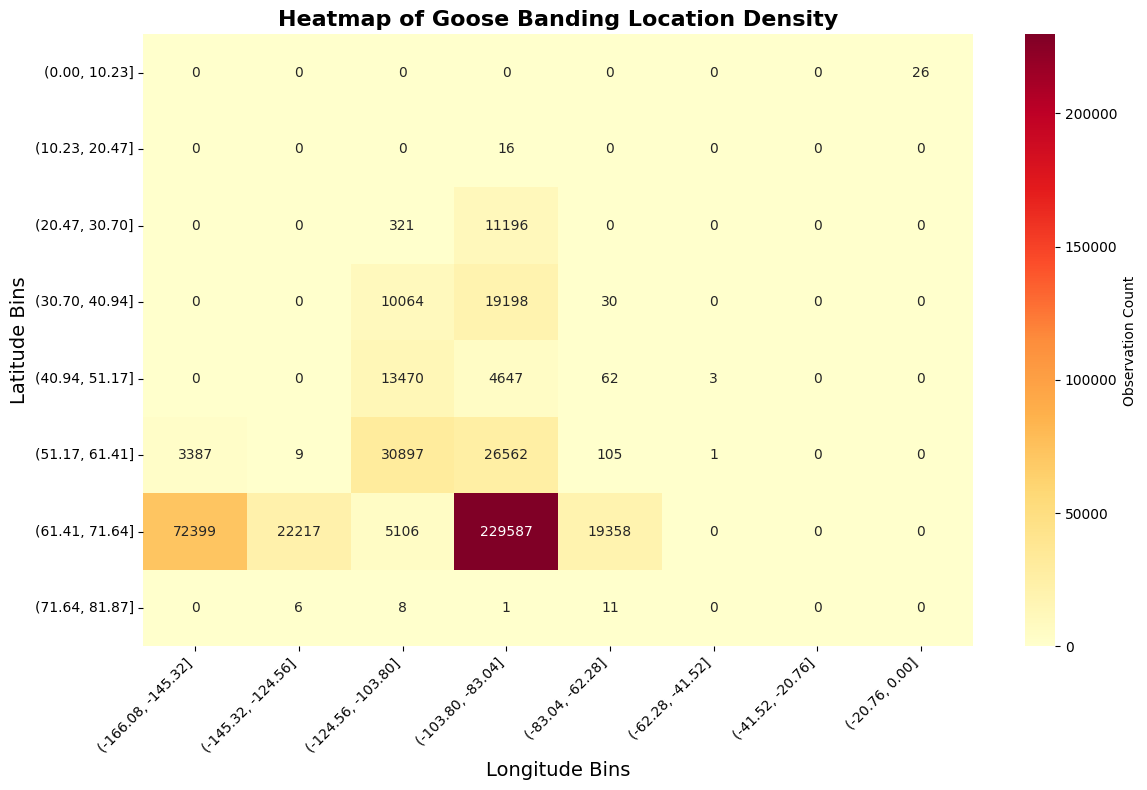

In [41]:
def create_heatmap(data, bins=8):
        
    # Get coordinate values, dropping NaN
    lat_values = data['LAT_DD'].dropna().values
    lon_values = data['LON_DD'].dropna().values
    
    if len(lat_values) == 0 or len(lon_values) == 0:
        print("Error: No valid coordinate data found!")
        print(f"LAT_DD non-null count: {len(lat_values)}")
        print(f"LON_DD non-null count: {len(lon_values)}")
        return
    
    print(f"Creating heatmap with {len(lat_values)} coordinate points")
    
    # Create bins
    lat_bins = np.linspace(lat_values.min(), lat_values.max(), bins + 1)
    lon_bins = np.linspace(lon_values.min(), lon_values.max(), bins + 1)
    
    # Calculate 2D histogram
    counts, lat_edges, lon_edges = np.histogram2d(lat_values, lon_values, 
                                                  bins=[lat_bins, lon_bins])
    
    # Create bin labels
    lat_labels = [f"({lat_edges[i]:.2f}, {lat_edges[i+1]:.2f}]" 
                  for i in range(len(lat_edges)-1)]
    lon_labels = [f"({lon_edges[i]:.2f}, {lon_edges[i+1]:.2f}]" 
                  for i in range(len(lon_edges)-1)]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(counts, 
                xticklabels=lon_labels,
                yticklabels=lat_labels,
                cmap='YlOrRd',
                cbar_kws={'label': 'Observation Count'},
                annot=True,
                fmt='.0f')
    
    plt.title('Heatmap of Goose Banding Location Density', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude Bins', fontsize=14)
    plt.ylabel('Latitude Bins', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Try to create the heatmap
create_heatmap(goose_data, bins=8)